**Homowerk 1 NLP**

This is the Colab Notebook for the first homework of NLP. I write and use it to create and train my model.
There you can find the final version (the ordered one).

To create this notebook I take some code and ispiration from the notebook presented at lessons and from 'https://scikit-learn.org/' for the confusion matrix.

# Import

In [1]:
#import
import re
from collections import Counter
from typing import *

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import random
import numpy as np
from sklearn.metrics import f1_score
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#fix random seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#path_train = '/content/drive/My Drive/results/'

Mounted at /content/drive


# Create Dataset

In this section (the larger one), I define all the function to model and change the format and the dimension of the dataset.
I create also the vocabulary and the weights to asign on each classes.

In [4]:
#function to load dataset from the path given
def load_dataset(path):
  data = pd.read_table(path, error_bad_lines=False, warn_bad_lines=False)
  # Remove the rows of the file that contain a "NaN" value.
  data.dropna() #if i remove this parameter it takes all the word (doesn't divide by phrases)
  return data

In [5]:
#load glove embeddings
import gensim.downloader as gen

wv = gen.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [6]:
#create vocabulary list
words = wv.vocab

In [7]:
#create a dictionary from glove: word to index and index to word

def default(words):
  dictionary_indices = {}
  dictionary_words = []
  #embeds = torch.randn(len(words), 100)
  dictionary_indices['pad'] = 0
  dictionary_words.append('pad')
  #embeds[0] = torch.zeros(100)
  dictionary_indices['unk'] = 1
  dictionary_words.append('unk')
  #embeds[1] = torch.rand(100)

  return dictionary_indices, dictionary_words#, embeds


def create_dictionary(words, wv):
  dictionary_indice, dictionary_words = default(words)
  for i in words:
    #print(i)
    if i != 'unk' and i != 'pad':
      dictionary_indice[i] = len(dictionary_words)
      #elem = wv[i]
      #elem = torch.from_numpy(elem)
      #embeds[len(dictionary_words)] = elem
      dictionary_words.append(i)

  return dictionary_indice, dictionary_words

In [8]:
#create 'word_to_indices' and 'indices_to_word' with all the words on glove-wiki
word_to_indices, indices_to_word = create_dictionary(words, wv)

In [9]:
#transform data frame in list
def create_list(train_data):
  c = 0
  n_word = 0
  max = 0
  lista_train= {}
  lista = []
  for i in range(0, len(train_data)):
    if(train_data['#'][i] == '#'):
      lista_train[c] = lista
      if max < n_word:
        max = n_word
      lista = []
      n_word = 0
      c += 1
    else:
      lista.append([train_data['#'][i], train_data['id'][i]])
      n_word += 1

  return lista_train, max

In [10]:
#transform data so each phrase has the same length
def all_same_length(train, max):
  for i in train:
    diff = max - len(train[i]) 
    if diff > 0:
      for x in range(0, diff):
        train[i].append(['pad', 'PAD'])

  return train

In [11]:
#Word into indices using vocabolary just create
def dataset_to_indices(lista_train, w):
  word_indices = {}
  c = 0

  for i in lista_train:
    indices = []
    for j in lista_train[i]:
      #print(j[1])
      try:
        indices.append(w[j[0]])
      except:
        indices.append(1) #if the word isn't on dictionary
    word_indices[c] = indices
    c += 1
  return word_indices

In [12]:
#Increase dicrionary with unknown train words and encode phrases
def training_to_indices(lista_train, unigram, biagram, triagram, quadrigram, word_to_indices, indices_to_word):
  word_indices = {}
  c = 0

  for i in lista_train:
    indices = []
    for j in lista_train[i]:
      #print(j[1])
      try:
        indices.append(word_to_indices[j[0]])
      except:
        word_to_indices[j[0]] = len(indices_to_word)
        indices.append(len(indices_to_word)) #if the word isn't on dictionary
        indices_to_word.append(j[0])
    word_indices[c] = indices
    c += 1

  for i in unigram:
    #print('i: ', i)
    indices = []
    for j in unigram[i]:
      #print('j: ',j)
      indices.append(word_to_indices[j[0]])
    word_indices[c] = indices
    c += 1

  for i in biagram:
    #print('i: ', i)
    indices = []
    for j in biagram[i]:
      #print('j: ',j)
      indices.append(word_to_indices[j[0]])
    word_indices[c] = indices
    c += 1

  for i in triagram:
    indices = []
    for j in triagram[i]:
      indices.append(word_to_indices[j[0]])
    word_indices[c] = indices
    c += 1

  for i in quadrigram:
    indices = []
    for j in quadrigram[i]:
      indices.append(word_to_indices[j[0]])
    word_indices[c] = indices
    c += 1


  return word_indices, word_to_indices, indices_to_word

In [13]:
#create 'indices_to_label' and 'label_to_indices'
label_to_indices = {'PAD' : 0, 'O' : 1, 'B-PER' : 2,'I-PER' : 3,'B-LOC' : 4,'I-LOC' : 5,'B-GRP' : 6,'I-GRP' : 7,'B-CORP' : 8,'I-CORP' : 9,'B-PROD' : 10,'I-PROD' : 11,'B-CW' : 12,'I-CW' : 13}
indices_to_label = ['PAD', 'O', 'B-PER' ,'I-PER' ,'B-LOC' ,'I-LOC' ,'B-GRP' ,'I-GRP' ,'B-CORP' ,'I-CORP' ,'B-PROD' ,'I-PROD' ,'B-CW' ,'I-CW']

In [14]:
#encode all labels of training set
def label_index_train(lista_train, unigram, biagram, triagram, quadrigram, l):
  word_label = {}
  a = {'PAD' : 0, 'O' : 0, 'B-PER' : 0,'I-PER' : 0,'B-LOC' : 0,'I-LOC' : 0,'B-GRP' : 0,'I-GRP' : 0,'B-CORP' : 0,'I-CORP' : 0,'B-PROD' : 0,'I-PROD' : 0,'B-CW' : 0,'I-CW' : 0}
  c = 0

  for i in lista_train:
    label = []
    for j in lista_train[i]:
      #print(j[1])
      label.append(l[j[1]])
      a[j[1]] += 1
    word_label[c] = label
    c += 1

  for i in unigram:
    label = []
    for j in unigram[i]:
      label.append(l[j[1]])
      a[j[1]] += 1
    word_label[c] = label
    c += 1

  for i in biagram:
    label = []
    for j in biagram[i]:
      label.append(l[j[1]])
      a[j[1]] += 1
    word_label[c] = label
    c += 1

  for i in triagram:
    label = []
    for j in triagram[i]:
      label.append(l[j[1]])
      a[j[1]] += 1
    word_label[c] = label
    c += 1

  for i in quadrigram:
    label = []
    for j in quadrigram[i]:
      label.append(l[j[1]])
      a[j[1]] += 1
    word_label[c] = label
    c += 1

    

  return word_label, a

In [15]:
#label to index (for validation)
def label_index(lista_train, l):
  word_label = {}
  a = {'PAD' : 0, 'O' : 0, 'B-PER' : 0,'I-PER' : 0,'B-LOC' : 0,'I-LOC' : 0,'B-GRP' : 0,'I-GRP' : 0,'B-CORP' : 0,'I-CORP' : 0,'B-PROD' : 0,'I-PROD' : 0,'B-CW' : 0,'I-CW' : 0}
  c = 0

  for i in lista_train:
    label = []
    for j in lista_train[i]:
      #print(j[1])
      label.append(l[j[1]])
      a[j[1]] += 1
    word_label[c] = label
    c += 1
  return word_label, a

In [16]:
#create training set (put together all the upper functions)
def dataset_creator_lstm_training(data, word_to_indices, indices_to_word, label_to_indices):
  lista, max = create_list(data)

  same_length = all_same_length(lista, max)
  word_indices, word_to_indices, indices_to_word = training_to_indices(same_length, [], [], [], [], word_to_indices, indices_to_word)
  label_ind, count_classes = label_index_train(same_length, [], [], [], [], label_to_indices)
  data = {}
  for i in range(0, len(word_indices)):
    data[i]={'inputs': torch.LongTensor(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data, count_classes, word_to_indices, indices_to_word

In [17]:
#create validation (and test) set (put together all the upper functions)
def dataset_creator_lstm(data, word_to_indices, label_to_indices):
  lista, max = create_list(data)
  same_length = all_same_length(lista, max)
  word_indices = dataset_to_indices(same_length, word_to_indices)
  label_ind, count_classes = label_index(same_length, label_to_indices)

  data = {}
  for i in range(0, len(word_indices)):
    data[i]={'inputs': torch.LongTensor(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data, count_classes

In [18]:
#function that create the weights for cross entropy function
def param_classes(count_classes, params):
  sum = 0
  vec = [0]
  for i in count_classes:
    if i is not 'PAD':
      sum += count_classes[i]
  for i in count_classes:
    if i is not 'PAD':
      a = count_classes[i]/sum
      #vec.append(1.0/a)
      vec.append(1-a)

  #for i in range(2, len(vec)):
  #  vec[i] *= 1.5
  
  params.class_vector = torch.tensor(vec)

In [19]:
#create dataloader and full vocabulary
from torch.utils.data import DataLoader
import torch.optim as optim
#device = "cuda"
training_data_cnn = load_dataset('/content/drive/MyDrive/data (1)/train.tsv')
dev_data_cnn = load_dataset('/content/drive/MyDrive/data (1)/dev.tsv')
trainingset_lstm, count_classes_train, word_to_indices, indices_to_word = dataset_creator_lstm_training(training_data_cnn, word_to_indices, indices_to_word, label_to_indices)
devset_lstm, count_classes_devset = dataset_creator_lstm(dev_data_cnn, word_to_indices, label_to_indices)

train_dataset_lstm = DataLoader(trainingset_lstm, batch_size=128, shuffle=True)
valid_dataset_lstm = DataLoader(devset_lstm, batch_size=128, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  


In [24]:
#create embed's matrix
def create_embed_weights(word_to_indices, wv):
  embeds = torch.randn(len(word_to_indices), 300)
  embeds[0] = torch.zeros(300)
  embeds[1] = torch.rand(300)
  for i in word_to_indices:
    if i is not 'pad'and i is not 'unk':
      try:
        elem = wv[i]
        elem = torch.from_numpy(elem)
        embeds[word_to_indices[i]] = elem
      except:
        embeds[word_to_indices[i]] = torch.rand(300)
  return embeds

In [41]:
#create embeds
embeds_pretrained = create_embed_weights(word_to_indices, wv)

# Parameters

Set the hyperparameters for the model. 
I have created an external class (like in  Notebook of Post-Tagging) because is easyer to modify.

In [42]:
#class params to set all the hyperparameters
class HParams_bilstm():
    vocab_size = len(indices_to_word)
    hidden_dim = 128
    embedding_dim = 300
    num_classes = len(indices_to_label)
    bidirectional = True
    num_layers = 2
    dropout = 0.005
    embeddings = embeds_pretrained
    class_vector = []
    
params = HParams_bilstm()

In [43]:
#set weights for cross entropy
param_classes(count_classes_train, params)

In [44]:
PATH = '/content/drive/MyDrive/data (1)/emebds11.pt'
torch.save(embeds_pretrained, PATH)

# Model

I have create a simple model:


In [45]:
#create model
class Embed_classifier(nn.Module):

    def __init__(self, hparams):
        super(Embed_classifier, self).__init__()
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        self.word_embedding.weight.data.copy_(hparams.embeddings)

        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers,
                            batch_first = True,
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0)
        
        lstm_output_dim = hparams.hidden_dim * 2
    
        self.fc1 = nn.Linear(lstm_output_dim, 64)

        self.dropout = nn.Dropout(hparams.dropout)

        self.classifier = nn.Linear(64, hparams.num_classes)

    
    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        x, (h, c) = self.lstm(embeddings)
        x = self.dropout(x)
        o = self.fc1(x)
        o = self.dropout(o)
        

        output = self.classifier(o)
        return output

In [46]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        loss_function,
        optimizer,
        label_vocab: indices_to_label,
        log_steps:int=10_000,
        log_level:int=2):
        """
        Args:
            model: the model we want to train.
            loss_function: the loss_function to minimize.
            optimizer: the optimizer used to minimize the loss_function.
        """
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer

        self.label_vocab = label_vocab
        self.log_steps = log_steps
        self.log_level = log_level
        self.label_vocab = label_vocab

    def train(self, train_dataset:Dataset, 
              valid_dataset:Dataset, 
              epochs:int=1):
        """
        Args:
            train_dataset: a Dataset or DatasetLoader instance containing
                the training instances.
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over
                epochs.
        """
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0
        for epoch in range(epochs):
            if self.log_level > 0:
                print(' Epoch {:03d}'.format(epoch + 1))

            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']
                self.optimizer.zero_grad()

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                # labels  [[1,2,3], [18, 12, 3]] after the view(-1) [1,2,3, 18, 12, 3]
                
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()

                if self.log_level > 1 and step % self.log_steps == self.log_steps - 1:
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))
            
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss
            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss = self.evaluate(valid_dataset)
            
            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}'.format(epoch, valid_loss))

        if self.log_level > 0:
            print('... Done!')
        
        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss
    

    def evaluate(self, valid_dataset):
        """
        Args:
            valid_dataset: the dataset to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataset.
        """
        valid_loss = 0.0
        # set dropout to 0!! Needed when we are in inference mode.
        self.model.eval()
        with torch.no_grad():
            for sample in valid_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                predictions = self.model(inputs)
                pred = predictions.view(-1, predictions.shape[-1])
                lab = labels.view(-1)
                #print('LABRLS: ', labels.tolist())
                top_label_scores, top_label_indices = torch.max(pred, -1)
                top_label_indices = top_label_indices.tolist()
                #print('PREDICTION: ', top_label_indices)
                sample_loss = self.loss_function(pred, lab)
                valid_loss += sample_loss.tolist()
                f1_score1 = f1_score(lab.data, top_label_indices, average="macro")
                print('f1: ', f1_score1)

        
        return valid_loss / len(valid_dataset)

    def predict(self, x):
        """
        Args:
            x: a tensor of indices.
        Returns: 
            A list containing the predicted POS tag for each token in the
            input sentences.
        """
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            predictions = torch.argmax(logits, -1)
            return logits, predictions
    
    


# Training

In [47]:
bilstm_embed_classifier = Embed_classifier(params)#.cuda()

In [48]:
bilstm_trainer = Trainer(
    model = bilstm_embed_classifier,
    loss_function = nn.CrossEntropyLoss(weight=params.class_vector, ignore_index=label_to_indices['PAD']),
    optimizer = torch.optim.Adam(bilstm_embed_classifier.parameters()), #lr=0.006
    label_vocab=indices_to_label
)

In [ ]:
bilstm_trainer.train(train_dataset_lstm, valid_dataset_lstm, 6)
PATH = '/content/drive/MyDrive/data (1)/model_prova1.pt'
torch.save(bilstm_embed_classifier, PATH)
#torch.save(bilstm_embed_classifier.state_dict(), PATH)

Training ...
 Epoch 001
	[E:  0] train loss = 1.2813
f1:  0.49520657224123027
f1:  0.44371812814134143
f1:  0.4794639623316116
f1:  0.43801838888985994
f1:  0.4564337965646419
f1:  0.4108731128444825
  [E:  0] valid loss = 0.6842
 Epoch 002
	[E:  1] train loss = 0.5204
f1:  0.5673852947792597
f1:  0.5512076554276761
f1:  0.5635470930286383
f1:  0.5173189643583151
f1:  0.5204331253917803
f1:  0.5019157341979196
  [E:  1] valid loss = 0.5359
 Epoch 003
	[E:  2] train loss = 0.3337
f1:  0.5794384729961038
f1:  0.5708326279844964
f1:  0.5774498765444795
f1:  0.5364975814291415
f1:  0.5198896713940628
f1:  0.5340827327331615
  [E:  2] valid loss = 0.4963
 Epoch 004
	[E:  3] train loss = 0.2069
f1:  0.6461555222959197
f1:  0.5823369712466245
f1:  0.6225941882739837
f1:  0.5845505316059848
f1:  0.5802762256849815
f1:  0.5642486616984699
  [E:  3] valid loss = 0.5315
 Epoch 005
	[E:  4] train loss = 0.1237
f1:  0.6605955215552743
f1:  0.6412823072371545
f1:  0.6312340227431752
f1:  0.595481595

# Prediction

Predict the Validation set and create the Confusion Matrix associated

In [34]:
#create validation (and test) set (put together all the upper functions)
def dataset_prediction(data, word_to_indices, label_to_indices):
  lista, _ = create_list(data)
  word_indices = dataset_to_indices(lista, word_to_indices)
  label_ind, count_classes = label_index(lista, label_to_indices)

  data = {}
  for i in range(0, len(word_indices)):
    data[i]={'inputs': torch.LongTensor(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data, count_classes

In [35]:
#create validation dataloader for prediction
dev_data_cnn = load_dataset('/content/drive/MyDrive/data (1)/dev.tsv')
devset_lstm, _ = dataset_creator_lstm(dev_data_cnn, word_to_indices, label_to_indices)
valid_dataset_lstm = DataLoader(devset_lstm, batch_size=128, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  


In [36]:
pred = []
logit = []
true_label = []
result = []
true_result = []
for i in valid_dataset_lstm:
  inputs = i['inputs']
  labels = i['outputs']
  logits, predict = bilstm_trainer.predict(inputs)
  for i in range(0, predict.size(dim=0)):
    pre = predict[i].numpy()
    lab = labels[i].numpy()
    pred.append(pre)
    true_label.append(lab)
  for i in pred:
    for j in i:
      
      result.append(j)
  for i in true_label:
    for j in i:
      true_result.append(j)

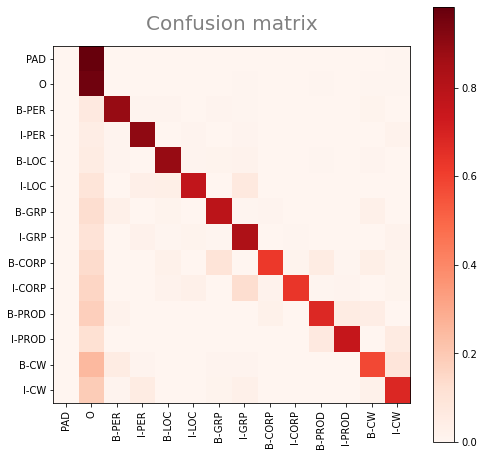

In [40]:
plot_matrix(result, true_result)

In [39]:
def plot_matrix(predict, label):
                c_matrix = confusion_matrix(label, predict, normalize='true')
                plt.figure(figsize=(8,8))
                plt.imshow(c_matrix, cmap="Reds")
                plt.title('Confusion matrix', fontsize=20, color = 'grey', pad=16)
                plt.xticks(np.arange( 14),labels= ['PAD', 'O', 'B-PER' ,'I-PER' ,'B-LOC' ,'I-LOC' ,'B-GRP' ,'I-GRP' ,'B-CORP' ,'I-CORP' ,'B-PROD' ,'I-PROD' ,'B-CW' ,'I-CW'], rotation = 90 )
                plt.yticks(np.arange( 14),labels= ['PAD', 'O', 'B-PER' ,'I-PER' ,'B-LOC' ,'I-LOC' ,'B-GRP' ,'I-GRP' ,'B-CORP' ,'I-CORP' ,'B-PROD' ,'I-PROD' ,'B-CW' ,'I-CW'] )
                plt.colorbar()

                plt.show()
